## Setup

In [1]:
!pip install torch-tensorrt==2.3.0 --extra-index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
ERROR: Ignored the following yanked versions: 0.0.0
ERROR: Could not find a version that satisfies the requirement torch-tensorrt==2.3.0 (from versions: 0.0.0.post1)
ERROR: No matching distribution found for torch-tensorrt==2.3.0


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

torch.cuda.is_available()

True

In [3]:
!ros2 topic info /camera_ids/camera_info

1726673240.032359 [42]       ros2: config: //CycloneDDS/Domain/General: 'NetworkInterfaceAddress': deprecated element (/root/.ros/cyclonedds.xml line 5)
Unknown topic '/camera_ids/camera_info'


In [4]:
# Training is performed on (3, 518, 518) images
# Evaluation in paper is performed on (3, 518, <some_multiple_of_14>) or (3, <some_multiple_of_14>, 518) with 518 for the smaller dimension and while keeping the original aspect ratio
# Paper states that inference works on other image scales as well (basically as long as dims are multiples of 14?)
shape_original = (1, 3, 1332, 2048)
min_size_resized = 518
base = 14

import nimbro_depthanything.transforms as transforms

shape_input = transforms.resize_shape_to_multiple_of_base(shape_original, min_size_resized=min_size_resized, base=base)
shape_input

(1, 3, 518, 798)

## Export to ONNX

In [5]:
# Dynamic shapes are currectly not working, so this is currectly not needed
# !pip install onnxscript

In [6]:
import nimbro_depthanything.scripts.export_model as export_model

export_model.export_model("depth_anything_v2_metric_hypersim_vits", shape_original=shape_original, min_size_resized=min_size_resized, base=base)

xFormers not available
xFormers not available


Exporting model ...


/root/colcon_ws/src/nimbro_depthanything/nimbro_depthanything/models/dinov2_layers/patch_embed.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert H % patch_H == 0, f"Input image height {H} is not a multiple of patch height {patch_H}"
/root/colcon_ws/src/nimbro_depthanything/nimbro_depthanything/models/dinov2_layers/patch_embed.py:74: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert W % patch_W == 0, f"Input image width {W} is not a multiple of patch width: {patch_W}"
/root/colcon_ws/src/nimbro_depthanything/nimbro_depthanything/models/dino

Model exported to /root/colcon_ws/src/nimbro_depthanything/resources/models_onnx/depth_anything_v2_metric_hypersim_vits.onnx


## Build engine

In [8]:
import nimbro_depthanything.scripts.build_engine as build_engine

build_engine.build_engine("depth_anything_v2_metric_hypersim_vits", limit_memory_workspace=1 << 31)

Building tensorrt engine ...
[09/18/2024-18:37:52] [TRT] [I] [MemUsageChange] Init CUDA: CPU +0, GPU +0, now: CPU 430, GPU 3936 (MiB)
[09/18/2024-18:37:55] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +954, GPU +182, now: CPU 1384, GPU 4118 (MiB)
[09/18/2024-18:37:55] [TRT] [I] ----------------------------------------------------------------
[09/18/2024-18:37:55] [TRT] [I] Input filename:   /root/colcon_ws/src/nimbro_depthanything/resources/models_onnx/depth_anything_v2_metric_hypersim_vits.onnx
[09/18/2024-18:37:55] [TRT] [I] ONNX IR version:  0.0.8
[09/18/2024-18:37:55] [TRT] [I] Opset version:    17
[09/18/2024-18:37:55] [TRT] [I] Producer name:    pytorch
[09/18/2024-18:37:55] [TRT] [I] Producer version: 2.3.0
[09/18/2024-18:37:55] [TRT] [I] Domain:           
[09/18/2024-18:37:55] [TRT] [I] Model version:    0
[09/18/2024-18:37:55] [TRT] [I] Doc string:       
[09/18/2024-18:37:55] [TRT] [I] ----------------------------------------------------------------
[09/18/202

## Run

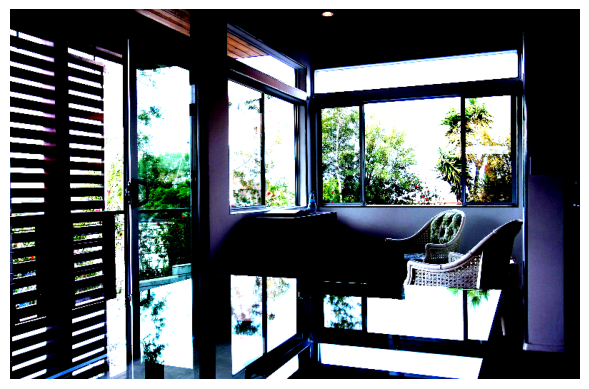

torch.Size([1, 3, 518, 798])


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as tv
import torchvision.transforms.v2 as tv_transforms

import nimbro_depthanything.transforms as transforms


modes_image = tv.io.ImageReadMode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = tv_transforms.Compose(
    [
        tv_transforms.PILToTensor(),
        transforms.ResizeToMultipleOfBase(min_size_resized=min_size_resized, base=base, mode_interpolation=transforms.MODES_INTERPOLATION.BICUBIC, use_antialiasing=False),
        tv_transforms.ToDtype(dtype=torch.float32, scale=True),
        tv_transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


def read_image(path, mode=modes_image.UNCHANGED, use_exif_orientation=False):
    image = tv.io.read_image(path, mode=mode, apply_exif_orientation=use_exif_orientation)
    return image


def visualize_image(image):
    din_a4 = np.array([210, 297]) / 25.4
    fig = plt.figure(figsize=din_a4)

    def subplot_image(image):
        ax = plt.gca()

        ax.set_axis_off()

        image_vis = (np.clip(image, 0.0, 1.0) * 255).astype(np.uint8)
        ax.imshow(image_vis, cmap="viridis" if image.shape[-1] == 1 else None)

    fig.add_subplot(3, 1, 1)
    subplot_image(image)

    plt.tight_layout()
    plt.show()


input = read_image("nimbro_depthanything/other/assets/examples/demo10.jpg")
input = input[None, ...]
input = transform(input)

visualize_image(input[0].numpy().transpose((1, 2, 0)))
print(input.shape)

xFormers not available
xFormers not available


True
tensor(79.0130)


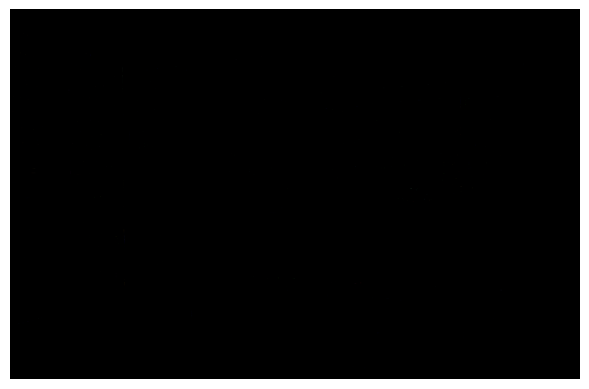

In [6]:
import torchvision.transforms.v2 as tv_transforms
import cv2

import nimbro_depthanything.models.util.transform as custom_transforms


def transform_original(image_original):
    image_original = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB) / 255.0

    transform = tv_transforms.Compose(
        [
            custom_transforms.Resize(
                width=shape_input[3],
                height=shape_input[2],
                resize_target=False,
                keep_aspect_ratio=True,
                ensure_multiple_of=14,
                resize_method="lower_bound",
                image_interpolation_method=cv2.INTER_CUBIC,
            ),
            custom_transforms.NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            custom_transforms.PrepareForNet(),
        ]
    )

    image_original = transform({"image": image_original})["image"]
    image_original = torch.from_numpy(image_original)

    return image_original


image_original = cv2.imread("nimbro_depthanything/other/assets/examples/demo10.jpg")
image_original = transform_original(image_original)

print(torch.allclose(image_original, input[0], atol=0.5, rtol=0.0001))
print(((input[0] - image_original) ** 2).sum())
visualize_image(((input[0] - image_original) ** 2).numpy().transpose((1, 2, 0)))

In [13]:
from pathlib import Path

import torchinfo

import nimbro_depthanything.config as config
from nimbro_depthanything.models import DepthAnythingV2

name_weights = "depth_anything_v2_metric_hypersim_vits"

path_weights = Path(config._PATH_DIR_WEIGHTS) / f"{name_weights}.pth"
weights = torch.load(f"{path_weights}", map_location="cpu")

model = DepthAnythingV2(**config.MODELS[name_weights]["kwargs"])
model.load_state_dict(weights)
model = model.eval()

try:
    print(torchinfo.summary(model, [input.shape], verbose=0))
except Exception as e:
    print(e)

Layer (type:depth-idx)                             Output Shape              Param #
DepthAnythingV2                                    [1, 518, 798]             --
├─DinoVisionTransformer: 1-1                       --                        526,848
│    └─PatchEmbed: 2-1                             [1, 2109, 384]            --
│    │    └─Conv2d: 3-1                            [1, 384, 37, 57]          226,176
│    │    └─Identity: 3-2                          [1, 2109, 384]            --
│    └─ModuleList: 2-2                             --                        --
│    │    └─NestedTensorBlock: 3-3                 [1, 2110, 384]            1,775,232
│    │    └─NestedTensorBlock: 3-4                 [1, 2110, 384]            1,775,232
│    │    └─NestedTensorBlock: 3-5                 [1, 2110, 384]            1,775,232
│    │    └─NestedTensorBlock: 3-6                 [1, 2110, 384]            1,775,232
│    │    └─NestedTensorBlock: 3-7                 [1, 2110, 384]            

### Compile model with Torch-TensorRT (JIT)

In [12]:
import torch_tensorrt

model_jit = torch.compile(model, backend="tensorrt", options=dict(enabled_precisions={torch.half}, workspace_size=0, optimization_level=5))

print(model_jit)

[autoreload of google.protobuf.descriptor failed: Traceback (most recent call last):
  File "/opt/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/opt/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/opt/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/opt/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: can't apply this __setattr__ to DescriptorMetaclass object
]
[autoreload of onnx.serialization failed: Traceback (most recent call last):
  File "/opt/venv/lib/python3.10/site-packages/IPyth

OptimizedModule(
  (_orig_mod): DepthAnythingV2(
    (pretrained): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-11): 12 x NestedTensorBlock(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=384, out_features=1152, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=384, out_features=384, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=384, out_features=1536, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=1536, out_fea

### Torch-TensorRT (Ahead-of-Time)

In [13]:
shape_input = (1, 3, 518, 798)

input_dummy = torch.rand(shape_input, device=device, dtype=torch.float32)

# dims = torch.export.dims("height", "width", min=518, max=1036)
# dim_height = torch.export.Dim("height")
# dim_width = torch.export.Dim("width")
# constraints = [
#     dim_height % 14 == 0,
#     dim_width % 14 == 0,
# ]
# torch.export.Constraint()

# exp = torch.export.export(
#     model,
#     (input_dummy,),
#     # dynamic_shapes={"x": {2: dim_height, 3: dim_width}},
#     # constraints=constraints,
# )

# input_dummy = torch_tensorrt.Input(min_shape=[1, 3, 518, 518], opt_shape=[1, 3, 798, 798], max_shape=[1, 3, 1036, 1036], dtype=torch.float32)
# trt_gm = torch_tensorrt.dynamo.compile(exp, inputs=[input_dummy])

path_exported_program = Path(config._PATH_DIR_ENGINES).parent / "exported_programs" / "depth_anything_v2_metric_hypersim_vits"
path_exported_program.parent.mkdir(parents=True, exist_ok=True)

trt_gm = torch_tensorrt.compile(model, ir="default", inputs=[input_dummy], enabled_precisions={torch.float16})
torch_tensorrt.save(trt_gm, path_exported_program, inputs=[input_dummy])

model_aot = torch.export.load(path_exported_program).module()

INFO:torch_tensorrt._compile:ir was set to default, using dynamo frontend


INFO:torch_tensorrt.dynamo._compiler:Compilation Settings: CompilationSettings(enabled_precisions={<dtype.f16: 6>}, debug=False, workspace_size=0, min_block_size=5, torch_executed_ops=set(), pass_through_build_failures=False, max_aux_streams=None, version_compatible=False, optimization_level=None, use_python_runtime=False, truncate_double=False, use_fast_partitioner=True, enable_experimental_decompositions=False, device=Device(type=DeviceType.GPU, gpu_id=0), require_full_compilation=False, disable_tf32=False, assume_dynamic_shape_support=False, sparse_weights=False, refit=False, engine_capability=<EngineCapability.STANDARD: 1>, num_avg_timing_iters=1, dla_sram_size=1048576, dla_local_dram_size=1073741824, dla_global_dram_size=536870912, dryrun=False, hardware_compatible=False)

INFO:torch_tensorrt [TensorRT Conversion Context]:[MemUsageChange] Init CUDA: CPU +0, GPU +0, now: CPU 1357, GPU 18796 (MiB)
INFO:torch_tensorrt [TensorRT Conversion Context]:[MemUsageChange] Init builder kernel

### TensorRT

In [7]:
from pathlib import Path
import nimbro_depthanything.config as config

import tensorrt as trt
from torch_tensorrt.fx import TRTModule

path_engine = Path(config._PATH_DIR_ENGINES) / "depth_anything_v2_metric_hypersim_vits.engine"

logger = trt.Logger(trt.Logger.INFO)
runtime = trt.Runtime(logger)

with open(path_engine, "rb") as file_engine:
    engine_serialized = file_engine.read()

engine = runtime.deserialize_cuda_engine(engine_serialized)
engine.get_tensor_shape("input")

model_trt = TRTModule(
    engine=engine,
    input_names=["input"],
    output_names=["output"],
)

ModuleNotFoundError: No module named 'torch_tensorrt'

### Test

In [9]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
with torch.inference_mode():
    input = input.to(device)
    model = model.to(device)

    s = time.time()
    for _ in range(1000):
        output = model(input)
    e = time.time()
    print(e - s)

    input = input.cpu()
    model = model.cpu()

13.80853796005249


In [16]:
with torch.inference_mode():
    stream = torch.cuda.Stream()
    with torch.cuda.stream(stream):
        input = input.to(device)
        model_jit = model_jit.to(device)

        # Trigger compilation
        output = model_jit(input)

        s = time.time()
        for _ in range(1000):
            output = model_jit(input)
        e = time.time()
        print(e - s)

        input = input.cpu()
        model_jit = model_jit.cpu()

NameError: name 'model_jit' is not defined

In [35]:
with torch.inference_mode():
    stream = torch.cuda.Stream()
    with torch.cuda.stream(stream):
        input = input.to(device)
        model_aot = model_aot.to(device)

        s = time.time()
        for _ in range(1000):
            output = model_aot(input)
        e = time.time()
        print(e - s)

        input = input.cpu()
        model_aot = model_aot.cpu()

2.540628433227539


In [17]:
with torch.inference_mode():
    stream = torch.cuda.Stream()
    with torch.cuda.stream(stream):
        input = input.to(device)
        model_trt = model_trt.to(device)

        s = time.time()
        for _ in range(1000):
            output = model_trt(input)
        e = time.time()
        print(e - s)

        input = input.cpu()
        model_trt = model_trt.cpu()

1.7531163692474365


torch.Size([1, 1332, 2048])


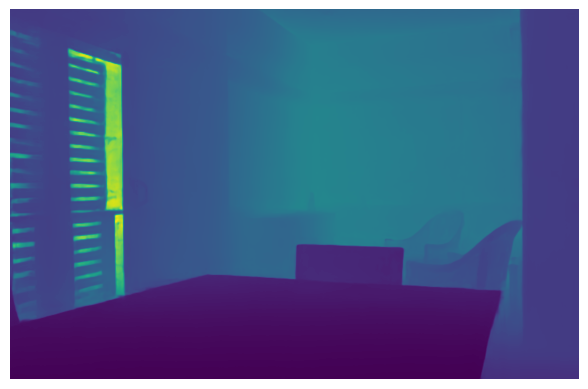

In [44]:
output = output[:, None, :, :]
output = torch.nn.functional.interpolate(output, (shape_original[2], shape_original[3]), mode="bilinear", align_corners=True)
output = output[0]
output = output.cpu()
output = output / output.max()

print(output.shape)
visualize_image(output.numpy().transpose((1, 2, 0)))

In [ ]:
stream = torch.cuda.Stream(device=device)

output = torch.ones((1, 160000), device=device)
bindings = [int(input_image.data_ptr()), int(output.data_ptr())]

with engine.create_execution_context() as context:
    context.execute_async_v2(bindings, stream_handle=stream.cuda_stream)
    stream.synchronize()

In [ ]:
depth = output.reshape()

plt.imshow(depth.permute((1, 2, 0)))

In [ ]:
with engine.create_execution_context() as context:

    context.set_tensor_address(name, ptr)
    context.set_input_shape("foo", (3, 150, 250))

    stream = torch.cuda.Stream(device=device)
    context.execute_async_v3(bindings=[int(d_input), int(d_output)], stream_handle=stream.cuda_stream)
    stream.synchronize()

    input_shape = context.get_tensor_shape("input")
    output_shape = context.get_tensor_shape("output")
    h_input = cuda.pagelocked_empty(trt.volume(input_shape), dtype=np.float32)
    h_output = cuda.pagelocked_empty(trt.volume(output_shape), dtype=np.float32)
    d_input = cuda.mem_alloc(h_input.nbytes)
    d_output = cuda.mem_alloc(h_output.nbytes)
    stream = cuda.Stream()

    # Copy the input image to the pagelocked memory
    np.copyto(h_input, input_image.ravel())

    # Copy the input to the GPU, execute the inference, and copy the output back to the CPU
    cuda.memcpy_htod_async(d_input, h_input, stream)
    context.execute_async_v2(bindings=[int(d_input), int(d_output)], stream_handle=stream.handle)
    cuda.memcpy_dtoh_async(h_output, d_output, stream)
    stream.synchronize()
    depth = h_output

    # # Process the depth output
    # depth = np.reshape(depth, output_shape[2:])
    # depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    # depth = depth.astype(np.uint8)
    # depth = cv2.resize(depth, (orig_w, orig_h))

    # # Save the depth map
    # img_name = os.path.basename(args.img)
    # if args.grayscale:
    #     cv2.imwrite(f'{args.outdir}/{img_name[:img_name.rfind(".")]}_depth.png', depth)
    # else:
    #     colored_depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)
    #     cv2.imwrite(f'{args.outdir}/{img_name[:img_name.rfind(".")]}_depth.png', colored_depth)

In [ ]:
#!trtexec --onnx=resnet50-v1-12.onnx --shapes=data:4x3x224x224 --fp16 --noDataTransfers --useCudaGraph --useSpinWait

In [ ]:
import argparse
import os
import cv2
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
import tensorrt as trt
from depth_anything.util.transform import load_image


def run(args):
    # Create the output directory if it doesn't exist
    os.makedirs(args.outdir, exist_ok=True)
    input_image, (orig_h, orig_w) = load_image(args.img)

    # Create logger and load the TensorRT engine
    logger = trt.Logger(trt.Logger.WARNING)
    with open(args.engine, "rb") as f, trt.Runtime(logger) as runtime:
        engine = runtime.deserialize_cuda_engine(f.read())

    with engine.create_execution_context() as context:
        input_shape = context.get_tensor_shape("input")
        output_shape = context.get_tensor_shape("output")
        h_input = cuda.pagelocked_empty(trt.volume(input_shape), dtype=np.float32)
        h_output = cuda.pagelocked_empty(trt.volume(output_shape), dtype=np.float32)
        d_input = cuda.mem_alloc(h_input.nbytes)
        d_output = cuda.mem_alloc(h_output.nbytes)
        stream = cuda.Stream()

        # Copy the input image to the pagelocked memory
        np.copyto(h_input, input_image.ravel())

        # Copy the input to the GPU, execute the inference, and copy the output back to the CPU
        cuda.memcpy_htod_async(d_input, h_input, stream)
        context.execute_async_v2(bindings=[int(d_input), int(d_output)], stream_handle=stream.handle)
        cuda.memcpy_dtoh_async(h_output, d_output, stream)
        stream.synchronize()
        depth = h_output

    # Process the depth output
    depth = np.reshape(depth, output_shape[2:])
    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    depth = depth.astype(np.uint8)
    depth = cv2.resize(depth, (orig_w, orig_h))

    # Save the depth map
    img_name = os.path.basename(args.img)
    if args.grayscale:
        cv2.imwrite(f'{args.outdir}/{img_name[:img_name.rfind(".")]}_depth.png', depth)
    else:
        colored_depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)
        cv2.imwrite(f'{args.outdir}/{img_name[:img_name.rfind(".")]}_depth.png', colored_depth)


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Run depth estimation with a TensorRT engine.")
    parser.add_argument("--img", type=str, required=True, help="Path to the input image")
    parser.add_argument("--outdir", type=str, default="./vis_depth", help="Output directory for the depth map")
    parser.add_argument("--engine", type=str, required=True, help="Path to the TensorRT engine")
    parser.add_argument("--grayscale", action="store_true", help="Save the depth map in grayscale")

    args = parser.parse_args()
    run(args)

In [ ]:
# Engine builder
        builder = trt.Builder(logger)
        config = builder.create_builder_config()
        workspace = int(self.args.workspace * (1 << 30))
        if is_trt10:
            config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, workspace)
        else:  # TensorRT versions 7, 8
            config.max_workspace_size = workspace
        flag = 1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
        network = builder.create_network(flag)
        half = builder.platform_has_fast_fp16 and self.args.half
        int8 = builder.platform_has_fast_int8 and self.args.int8
        # Read ONNX file
        parser = trt.OnnxParser(network, logger)
        if not parser.parse_from_file(f_onnx):
            raise RuntimeError(f"failed to load ONNX file: {f_onnx}")

        # Network inputs
        inputs = [network.get_input(i) for i in range(network.num_inputs)]
        outputs = [network.get_output(i) for i in range(network.num_outputs)]
        for inp in inputs:
            LOGGER.info(f'{prefix} input "{inp.name}" with shape{inp.shape} {inp.dtype}')
        for out in outputs:
            LOGGER.info(f'{prefix} output "{out.name}" with shape{out.shape} {out.dtype}')

        if self.args.dynamic:
            shape = self.im.shape
            if shape[0] <= 1:
                LOGGER.warning(f"{prefix} WARNING ⚠️ 'dynamic=True' model requires max batch size, i.e. 'batch=16'")
            profile = builder.create_optimization_profile()
            min_shape = (1, shape[1], 32, 32)  # minimum input shape
            max_shape = (*shape[:2], *(max(1, self.args.workspace) * d for d in shape[2:]))  # max input shape
            for inp in inputs:
                profile.set_shape(inp.name, min=min_shape, opt=shape, max=max_shape)
            config.add_optimization_profile(profile)

        LOGGER.info(f"{prefix} building {'INT8' if int8 else 'FP' + ('16' if half else '32')} engine as {f}")
        if int8:
            config.set_flag(trt.BuilderFlag.INT8)
            config.set_calibration_profile(profile)
            config.profiling_verbosity = trt.ProfilingVerbosity.DETAILED

            class EngineCalibrator(trt.IInt8Calibrator):
                def __init__(
                    self,
                    dataset,  # ultralytics.data.build.InfiniteDataLoader
                    batch: int,
                    cache: str = "",
                ) -> None:
                    trt.IInt8Calibrator.__init__(self)
                    self.dataset = dataset
                    self.data_iter = iter(dataset)
                    self.algo = trt.CalibrationAlgoType.ENTROPY_CALIBRATION_2
                    self.batch = batch
                    self.cache = Path(cache)

                def get_algorithm(self) -> trt.CalibrationAlgoType:
                    """Get the calibration algorithm to use."""
                    return self.algo

                def get_batch_size(self) -> int:
                    """Get the batch size to use for calibration."""
                    return self.batch or 1

                def get_batch(self, names) -> list:
                    """Get the next batch to use for calibration, as a list of device memory pointers."""
                    try:
                        im0s = next(self.data_iter)["img"] / 255.0
                        im0s = im0s.to("cuda") if im0s.device.type == "cpu" else im0s
                        return [int(im0s.data_ptr())]
                    except StopIteration:
                        # Return [] or None, signal to TensorRT there is no calibration data remaining
                        return None

                def read_calibration_cache(self) -> bytes:
                    """Use existing cache instead of calibrating again, otherwise, implicitly return None."""
                    if self.cache.exists() and self.cache.suffix == ".cache":
                        return self.cache.read_bytes()

                def write_calibration_cache(self, cache) -> None:
                    """Write calibration cache to disk."""
                    _ = self.cache.write_bytes(cache)

            # Load dataset w/ builder (for batching) and calibrate
            config.int8_calibrator = EngineCalibrator(
                dataset=self.get_int8_calibration_dataloader(prefix),
                batch=2 * self.args.batch,  # TensorRT INT8 calibration should use 2x batch size
                cache=str(self.file.with_suffix(".cache")),
            )

        elif half:
            config.set_flag(trt.BuilderFlag.FP16)

        # Free CUDA memory
        del self.model
        gc.collect()
        torch.cuda.empty_cache()

        # Write file
        build = builder.build_serialized_network if is_trt10 else builder.build_engine
        with build(network, config) as engine, open(f, "wb") as t:
            # Metadata
            meta = json.dumps(self.metadata)
            t.write(len(meta).to_bytes(4, byteorder="little", signed=True))
            t.write(meta.encode())
            # Model
            t.write(engine if is_trt10 else engine.serialize())

        return f, None

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter
import glob

files = glob.glob(r"gif/image_*.png")

image_array = []

for my_file in files:
    image = Image.open(my_file)
    image_array.append(image)


def update(i):
    im.set_array(image_array[i])
    return (im,)


ax = plt.gca()
im = ax.imshow(image_array[0], animated=True)

din_a4 = np.array([210, 297]) / 25.4
din_a4_landscape = din_a4[::-1]
fig = plt.figure(figsize=din_a4_landscape)

ani = FuncAnimation(fig, update, interval=40, blit=True, repeat=True, frames=22)
ani.save("test.gif", dpi=300, writer=PillowWriter(fps=0.3))

In [13]:
import glob
import contextlib
from PIL import Image

# filepaths
fp_in = "gif/image_*.png"
fp_out = "test.gif"

# use exit stack to automatically close opened images
with contextlib.ExitStack() as stack:
    # lazily load images
    imgs = (stack.enter_context(Image.open(f)) for f in sorted(glob.glob(fp_in)))

    # extract  first image from iterator
    img = next(imgs)

    img = img.quantize(colors=255, dither=0)
    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format="GIF", append_images=imgs, save_all=True, duration=3000, loop=0)